In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
from datatable import dt, fread
from utils.feature_eng import *

In [2]:
train_path = '/home/carlchao/Riiid-/CV/small_csv_file/cv1_train.csv'
valid_path = '/home/carlchao/Riiid-/CV/small_csv_file/cv1_valid.csv'
question_file = '/home/carlchao/Riiid_data/data/questions.csv'

In [3]:
%%time
# drop task_container_id, user_answer
feld_needed = ['row_id', 'timestamp','user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train = fread(train_path).to_pandas()[feld_needed]
valid = fread(valid_path).to_pandas()[feld_needed]

CPU times: user 3.97 s, sys: 334 ms, total: 4.3 s
Wall time: 591 ms


In [4]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,32933156,0,705741139,128,False,1,NaN,True
1,32933157,20666,705741139,7860,False,1,16000.0,False
2,32933158,39172,705741139,7922,False,1,19000.0,False
3,32933159,58207,705741139,156,False,1,17000.0,False
4,32933160,75779,705741139,51,False,1,17000.0,False


In [5]:
# fill with mean value for prior_question_elapsed_time
# note that `train.prior_question_elapsed_time.mean()` dose not work!
# please refer https://www.kaggle.com/its7171/can-we-trust-pandas-mean for detail.
# prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
# train['prior_question_elapsed_time_mean'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
# valid['prior_question_elapsed_time_mean'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

# use only last 30M training data for limited memory on kaggle env.
#train = train[-30000000:]

# part
questions_df = pd.read_csv(question_file)
en = Tags_encoder(5)
questions_df = pd.concat([questions_df, en.fit_transform(questions_df['tags'].fillna(' '))], 1)

train = pd.merge(train, questions_df[['question_id', 'part','PCA_0','PCA_3','PCA_4']], left_on = 'content_id', right_on = 'question_id', how = 'left')
valid = pd.merge(valid, questions_df[['question_id', 'part','PCA_0','PCA_3','PCA_4']], left_on = 'content_id', right_on = 'question_id', how = 'left')


train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

# answered correctly average for each content
content_df = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean']).reset_index()
content_df.columns = ['content_id', 'answered_correctly_avg_c']
train = pd.merge(train, content_df, on=['content_id'], how="left")
valid = pd.merge(valid, content_df, on=['content_id'], how="left")

In [6]:


def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict, content_dict, part_dict_sum, part_dict_count):
    
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    bool = np.zeros(len(df), dtype=np.int8)
    part_auc = np.zeros(len(df), dtype=np.int32)
    part_c = np.zeros(len(df), dtype=np.int32)
    
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly','content_id','part']].values)):

        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        part_auc[cnt] = part_dict_sum[int(row[3])-1][row[0]]
        part_c[cnt] = part_dict_count[int(row[3])-1][row[0]]

        answered_correctly_sum_u_dict[row[0]] += row[1]
        count_u_dict[row[0]] += 1

        part_dict_sum[int(row[3])-1][row[0]] += row[1]
        part_dict_count[int(row[3])-1][row[0]] += 1

        if row[2] not in content_dict[row[0]]:
#             bool[cnt] = content_dict[row[0]].count(row[2])
            content_dict[row[0]].append(row[2])
            bool[cnt] = 1
        else:
            bool[cnt] = 0

    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu, 'first_time': bool,'part_sum_u':part_auc,'part_count_u':part_c})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    user_feats_df['part_avg_u'] = user_feats_df['part_sum_u'] / user_feats_df['part_count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    
    return df

def add_user_feats_without_update(df, answered_correctly_sum_u_dict, count_u_dict, content_dict, part_dict_sum, part_dict_count):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    bool = np.zeros(len(df), dtype=np.int8)
    part_auc = np.zeros(len(df), dtype=np.int32)
    part_c = np.zeros(len(df), dtype=np.int32)
    
    for cnt,row in enumerate(df[['user_id','content_id','part']].values):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        part_auc[cnt] = part_dict_sum[int(row[3])-1][row[0]]
        part_c[cnt] = part_dict_count[int(row[3])-1][row[0]]
        
        
        if row[1] not in content_dict[row[0]]:
#             bool[cnt] = content_dict[row[0]].count(row[1])
            bool[cnt] = 1
        else:
            bool[cnt] = 0
            
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu, 'first_time': bool,'part_sum_u':part_auc,'part_count_u':part_c})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    user_feats_df['part_avg_u'] = user_feats_df['part_sum_u'] / user_feats_df['part_count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    
    return df

def update_user_feats(df, answered_correctly_sum_u_dict, count_u_dict, content_dict):
    for row in df[['user_id','answered_correctly','content_type_id','part']].values:
        if row[2] == 0:
            answered_correctly_sum_u_dict[row[0]] += row[1]
            count_u_dict[row[0]] += 1
            content_dict[row[0]].append(row[2])
            part_dict_sum[int(row[3])-1][row[0]] += row[1]
            part_dict_count[int(row[3])-1][row[0]] += 1

In [7]:
[1,1,2]

[1, 1, 2]

In [8]:
part_dict_sum = [ defaultdict(int) for i in range(7)]
part_dict_count = [ defaultdict(int) for i in range(7)]
answered_correctly_sum_u_dict = defaultdict(int)
count_u_dict = defaultdict(int)
content_dict = defaultdict(list)
times_dict = defaultdict(int)

In [9]:
# user stats features with loops
train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict, content_dict, part_dict_sum, part_dict_count)
train.to_pickle('preprocess_fea_v2/adjust_small_train.pickle')
valid = add_user_feats(valid, answered_correctly_sum_u_dict, count_u_dict, content_dict, part_dict_sum, part_dict_count )
valid.to_pickle('preprocess_fea_v2/adjust_small_valid.pickle')

In [10]:
import pickle

with open("preprocess_fea_v2/adjust_answered_correctly_sum_u_dict.pickle", "wb") as filename:  
    pickle.dump(answered_correctly_sum_u_dict, filename)
    filename.close()

with open("preprocess_fea_v2/adjust_count_u_dict.pickle", "wb") as filename:  
    pickle.dump(count_u_dict, filename)
    filename.close()

with open("preprocess_fea_v2/adjust_content_dict.pickle", "wb") as filename:  
    pickle.dump(content_dict, filename)
    filename.close()
    
with open("preprocess_fea_v2/adjust_part_dict_sum.pickle", "wb") as filename:  
    pickle.dump(part_dict_sum, filename)
    filename.close()
    
with open("preprocess_fea_v2/adjust_part_dict_count.pickle", "wb") as filename:  
    pickle.dump(part_dict_count, filename)
    filename.close()

In [11]:
#drop useless col
train.drop(['timestamp','user_id','content_id','content_type_id','question_id'], axis=1, inplace=True)
valid.drop(['timestamp','user_id','content_id','content_type_id','question_id'], axis=1, inplace=True)

# changing dtype to avoid lightgbm error
train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

In [12]:
TARGET = 'answered_correctly'
FEATS = ['answered_correctly_avg_u', 'answered_correctly_sum_u', 'count_u', 'answered_correctly_avg_c', 'part', 'prior_question_had_explanation', 'prior_question_elapsed_time','first_time']
FEATS = FEATS + ['PCA_0','PCA_3','PCA_4','part_avg_u', 'part_sum_u', 'part_count_u']
dro_cols = list(set(train.columns) - set(FEATS))
y_tr = train[TARGET]
y_va = valid[TARGET]
train.drop(dro_cols, axis=1, inplace=True)
valid.drop(dro_cols, axis=1, inplace=True)
_=gc.collect()

In [13]:
lgb_train = lgb.Dataset(train[FEATS], y_tr, categorical_feature=['part', 'prior_question_had_explanation'])
lgb_valid = lgb.Dataset(valid[FEATS], y_va, categorical_feature=['part', 'prior_question_had_explanation'])
del train, y_tr
_=gc.collect()

Training until validation scores don't improve for 400 rounds
[100]	training's binary_logloss: 0.543099	valid_1's binary_logloss: 0.543868
[200]	training's binary_logloss: 0.542221	valid_1's binary_logloss: 0.54294
[300]	training's binary_logloss: 0.541605	valid_1's binary_logloss: 0.542543
[400]	training's binary_logloss: 0.541102	valid_1's binary_logloss: 0.542215
[500]	training's binary_logloss: 0.540658	valid_1's binary_logloss: 0.542006
[600]	training's binary_logloss: 0.54028	valid_1's binary_logloss: 0.541872
[700]	training's binary_logloss: 0.539942	valid_1's binary_logloss: 0.541774
[800]	training's binary_logloss: 0.539618	valid_1's binary_logloss: 0.541698
[900]	training's binary_logloss: 0.539278	valid_1's binary_logloss: 0.541576
[1000]	training's binary_logloss: 0.538967	valid_1's binary_logloss: 0.541509
[1100]	training's binary_logloss: 0.538692	valid_1's binary_logloss: 0.541429
[1200]	training's binary_logloss: 0.538427	valid_1's binary_logloss: 0.541384
[1300]	traini

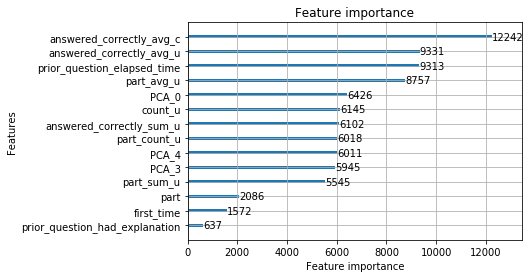

In [14]:
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=100,
                    num_boost_round=10000,
                    early_stopping_rounds= 400,
                    categorical_feature=['part', 'prior_question_had_explanation']
    
                )
print('auc:', roc_auc_score(y_va, model.predict(valid[FEATS])))
_ = lgb.plot_importance(model)

In [15]:
# tags useful 
# user for each part auc substract all user each part auc
# to do join lectures tags ==> question tags, lecture tags encode
# content_id useful

# ['part_1_boolean',
#  'part_2_boolean',
#  'part_3_boolean',
#  'part_4_boolean',
#  'part_5_boolean',
#  'part_6_boolean',
#  'part_7_boolean',
#  'type_of_concept_boolean',
#  'type_of_intention_boolean',
#  'type_of_solving_question_boolean',
#  'type_of_starter_boolean']

# optuna


In [16]:
#baseline: 75.84

## add tags6: 

##pca
# pca[0,1,2,3,4] : 76.01
# pca[0,1,2]: 75.99
# pca[0,3,4]: 76.00
# pca[0,3,4,5,6]: 76.00
## pca[0,3,4] + part feature: 76.33

## first time adjust + pca[0,3,4] + part feature: 75.53
